# HM2: Numerical Optimization for Logistic Regression.

### Name: [Your-Name?]


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM2/HM2.html


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [2]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [3]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [4]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.15022079 -0.06785286  0.13113606  0.0601941  -0.07282567  0.03868547
   0.09157447  0.05615367]]
test std = 
[[1.11320819 0.85616007 0.87911477 0.94033212 0.91747796 0.97380343
  1.12041778 1.01805204]]


## 1.4. Add a dimension of all ones

In [5]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [11]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [12]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [13]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [14]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [364]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5918014861637447
Objective value at t=2 is 0.5499858489249891
Objective value at t=3 is 0.5273695357020987
Objective value at t=4 is 0.513179368742786
Objective value at t=5 is 0.5035137628295492
Objective value at t=6 is 0.49659068175407184
Objective value at t=7 is 0.4914619697050814
Objective value at t=8 is 0.4875687558844574
Objective value at t=9 is 0.484557578055556
Objective value at t=10 is 0.48219340279969614
Objective value at t=11 is 0.48031404521688426
Objective value at t=12 is 0.4788043434958003
Objective value at t=13 is 0.47758062809720553
Objective value at t=14 is 0.47658094330971934
Objective value at t=15 is 0.47575866481585055
Objective value at t=16 is 0.475078211309901
Objective value at t=17 is 0.4745120931801235
Objective value at t=18 is 0.47403883961059873
Objective value at t=19 is 0.47364151672014865
Objective value at t=20 is 0.47330665158110347
Objective value at t=21 is 0.473023439

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [16]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [422]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
            
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [420]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5276967470729967
Objective value at epoch t=1 is 0.5103350208679391
Objective value at epoch t=2 is 0.4993443922811089
Objective value at epoch t=3 is 0.4975203507739917
Objective value at epoch t=4 is 0.49605778383918697
Objective value at epoch t=5 is 0.4905087747345546
Objective value at epoch t=6 is 0.4851253227868825
Objective value at epoch t=7 is 0.48414950008476276
Objective value at epoch t=8 is 0.4833227578419903
Objective value at epoch t=9 is 0.4806663708184523
Objective value at epoch t=10 is 0.47688930985794953
Objective value at epoch t=11 is 0.47756005240570465
Objective value at epoch t=12 is 0.4756970652952128
Objective value at epoch t=13 is 0.4756051249421155
Objective value at epoch t=14 is 0.4746047758759098
Objective value at epoch t=15 is 0.4737943963732917
Objective value at epoch t=16 is 0.47336423118353543
Objective value at epoch t=17 is 0.4728740595833726
Objective value at epoch t=18 is 0.4726539821476444
Objective value a

# 4. Compare GD with SGD

Plot objective function values against epochs.

C:\Users\Phoebus\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if __name__ == '__main__':
C:\Users\Phoebus\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Phoebus\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Phoebus\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be r

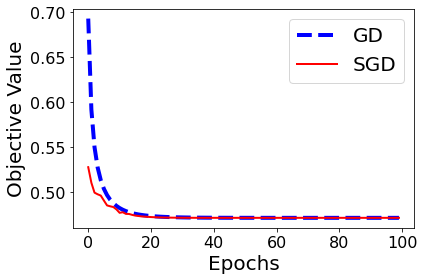

In [421]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [20]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [366]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.221875


In [367]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.234375


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [492]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i

import numpy as np
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    # Fill the function
    # Follow the implementation of stochastic_objective_gradient
    # Use matrix-vector multiplication; do not use FOR LOOP of vector-vector multiplications

    yx = numpy.multiply(yi, xi) # b-by-d matrix
#     print(yx.shape)
    yxw = numpy.dot(yx, w) # b-by-1 matrix
#     print(yxw.shape)
    
    # calculate objective function Q_i
    loss = numpy.mean(numpy.log(1 + numpy.exp(-yxw))) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    vec1 = numpy.exp(yxw) # b-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # b-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w # d-by-1 matrix
#     print(g.shape)
    
    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [500]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     display: display the print or not
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, dispaly, max_epoch=100, w=None):
    # Fill the function
    # Follow the implementation of sgd
    # Record one objective value per epoch (not per iteration!)

    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle b samples
        rand_indices = numpy.random.permutation(x.shape[0]) 
        
        objval = 0 # accumulate the objective values
        start = 0
        end = b
        for i in range(int(n/b)):
            x_rand = x[rand_indices[start:end], :]
            y_rand = y[rand_indices[start:end], :]
            start += b
            end += b
            obj, g = mb_stochastic_objective_gradient(w, x_rand, y_rand, lam, b)
            objval += obj
            w -= stepsize * g
#             print(obj)
        
        stepsize *= 0.9 # decrease step size
        objval /= (n/b)
        objvals[t] = objval
        if (display==1):
            print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

## 6.3. Run MB-SGD

In [539]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.1 # you must tune this parameter
display = 0 # do not display the print

# tune stepsize parameter
stepsize = [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
bestPara = stepsize[0]
minObjval = 99
print('Tune parameter of stepsize:')
for para in stepsize:
    print('When stepsize=%s ,'%str(para),end='')
    w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, para, display)
    print(' the last objective value=%s'%str(objvals_mbsgd8[-1]))
    if (objvals_mbsgd8[-1]<minObjval):
        minObjval = objvals_mbsgd8[-1]
        bestPara = para
print('\nSo, the best stepsize is %s'%str(bestPara))
    
display = 1 # display the print
print('\nUsing the best stepsize, the process of mini-batch SGD:')
wSgd8, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, para, display)
    

Tune parameter of stepsize:
When stepsize=0.05 , the last objective value=0.4714496133513144
When stepsize=0.1 , the last objective value=0.47130136931170663
When stepsize=0.2 , the last objective value=0.4713011781641039
When stepsize=0.3 , the last objective value=0.47130157207367757
When stepsize=0.5 , the last objective value=0.47130252775141096
When stepsize=0.7 , the last objective value=0.4713024109432918
When stepsize=0.9 , the last objective value=0.47130291726878476

So, the best stepsize is 0.2

Using the best stepsize, the process of mini-batch SGD:
Objective value at epoch t=0 is 0.5566009738199688
Objective value at epoch t=1 is 0.5359111955855013
Objective value at epoch t=2 is 0.5268787633433595
Objective value at epoch t=3 is 0.5185475402352188
Objective value at epoch t=4 is 0.5048850142739634
Objective value at epoch t=5 is 0.5078350228093595
Objective value at epoch t=6 is 0.5050385456306798
Objective value at epoch t=7 is 0.4993009776395663
Objective value at epoch

In [540]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.1 # you must tune this parameter
display = 0 # display the print or not

# tune stepsize parameter
stepsize = [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
bestPara = stepsize[0]
minObjval = 99
print('Tune parameter of stepsize:')
for para in stepsize:
    print('When stepsize=%s ,'%str(para),end='')
    w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, para, display)
    print(' the last objective value=%s'%str(objvals_mbsgd64[-1]))
    if (objvals_mbsgd64[-1]<minObjval):
        minObjval = objvals_mbsgd64[-1]
        bestPara = para
print('\nSo, the best stepsize is %s'%str(bestPara))
    
display = 1 # display the print
print('\nUsing the best stepsize, the process of mini-batch SGD:')
wSgd64, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, para, display)

Tune parameter of stepsize:
When stepsize=0.05 , the last objective value=0.5084182400709756
When stepsize=0.1 , the last objective value=0.48398185207438627
When stepsize=0.2 , the last objective value=0.4736418993877787
When stepsize=0.3 , the last objective value=0.47185703807203694
When stepsize=0.5 , the last objective value=0.4713350482514576
When stepsize=0.7 , the last objective value=0.471304956563735
When stepsize=0.9 , the last objective value=0.47130101749699316

So, the best stepsize is 0.9

Using the best stepsize, the process of mini-batch SGD:
Objective value at epoch t=0 is 0.5429086693835969
Objective value at epoch t=1 is 0.4858662645279367
Objective value at epoch t=2 is 0.48054659973984454
Objective value at epoch t=3 is 0.4799491531122434
Objective value at epoch t=4 is 0.47875927410278524
Objective value at epoch t=5 is 0.477067536291041
Objective value at epoch t=6 is 0.4771809565820678
Objective value at epoch t=7 is 0.4765899857448367
Objective value at epoch 

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

In [ ]:
# plot the 4 curves:

C:\Users\Phoebus\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Phoebus\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if sys.path[0] == '':
C:\Users\Phoebus\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  del sys.path[0]
C:\Users\Phoebus\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  
C:\Us

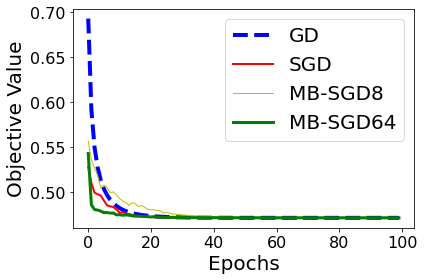

In [541]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mbsgd8 = range(len(objvals_mbsgd8))
epochs_mbsgd64 = range(len(objvals_mbsgd64))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
line2, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '-y', LineWidth=1)
line3, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, '-g', LineWidth=3)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['GD', 'SGD', 'MB-SGD8', 'MB-SGD64'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 8. Prediction

In [548]:
print('Using learned w in MB-SGD8:')
# evaluate training error
f_train = predict(wSgd8, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

# evaluate test error
f_test = predict(wSgd8, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Using learned w in MB-SGD8:
Training classification error is 0.221875
Test classification error is 0.234375


In [547]:
print('Using learned w in MB-SGD64:')
# evaluate training error
f_train = predict(wSgd64, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

# evaluate test error
f_test = predict(wSgd64, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Using learned w in MB-SGD64:
Training classification error is 0.2234375
Test classification error is 0.234375
